In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
from torchvision import models, transforms

In [ ]:
# Load the image
image_path = '/content/bulbul.jpg'
original_image = Image.open(image_path)

In [ ]:
# Define transformation for the classifier
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Converting class index into class name
with open('imagenet_class_index.json') as f:
    class_index = json.load(f)

idx_to_label = {int(key): value for key, value in class_index.items()}

for idx, label in idx_to_label.items():
    print(f'Index: {idx}, Class Name: {label}')

Index: 0, Class Name: tench, Tinca tinca
Index: 1, Class Name: goldfish, Carassius auratus
Index: 2, Class Name: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
Index: 3, Class Name: tiger shark, Galeocerdo cuvieri
Index: 4, Class Name: hammerhead, hammerhead shark
Index: 5, Class Name: electric ray, crampfish, numbfish, torpedo
Index: 6, Class Name: stingray
Index: 7, Class Name: cock
Index: 8, Class Name: hen
Index: 9, Class Name: ostrich, Struthio camelus
Index: 10, Class Name: brambling, Fringilla montifringilla
Index: 11, Class Name: goldfinch, Carduelis carduelis
Index: 12, Class Name: house finch, linnet, Carpodacus mexicanus
Index: 13, Class Name: junco, snowbird
Index: 14, Class Name: indigo bunting, indigo finch, indigo bird, Passerina cyanea
Index: 15, Class Name: robin, American robin, Turdus migratorius
Index: 16, Class Name: bulbul
Index: 17, Class Name: jay
Index: 18, Class Name: magpie
Index: 19, Class Name: chickadee
Index: 20, Class

In [ ]:
# Defining a function to zoom into images
def zoom_in(image, zoom_factor):
    width, height = image.size
    new_width = int(width * zoom_factor)
    new_height = int(height * zoom_factor)
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    return image.crop((left, top, right, bottom))

In [ ]:
# Defining a function to determine the confidence levels for each class
def classify_image(image_tensor):
    model = models.resnet50(pretrained=True)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities.numpy()

In [ ]:
# Creating a function to generate a composite image from all the zoomed images
def create_composite_image(zoomed_images, top_confidences, top_class_names, target_class_index=16):
    images_per_row = 3
    image_width, image_height = zoomed_images[0].size
    num_rows = (len(zoomed_images) + images_per_row - 1) // images_per_row
    composite_width = images_per_row * image_width
    composite_height = num_rows * (image_height + 50)
    composite_image = Image.new('RGB', (composite_width, composite_height), (255, 255, 255))
    try:
        font = ImageFont.truetype("arial.ttf", 150)
    except IOError:
        font = ImageFont.load_default()

    current_x = 0
    current_y = 0
    for i, (zoomed_image, confidence) in enumerate(zip(zoomed_images, top_confidences)):
        composite_image.paste(zoomed_image, (current_x, current_y))
        if top_class_names[i][0] == 'bulbul':
            confidence_text = f'Confidence: {confidence[0]:.2f}'
            draw = ImageDraw.Draw(composite_image)
            text_bbox = draw.textbbox((current_x, current_y + image_height), confidence_text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            background_rect = (current_x, current_y + image_height, current_x + text_width, current_y + image_height + text_height + 10)
            draw.rectangle(background_rect, fill=(255, 255, 255))
            draw.text((current_x, current_y + image_height), confidence_text, fill=(0, 0, 0), font=font)
        current_x += image_width
        if (i + 1) % images_per_row == 0:
            current_x = 0
            current_y += image_height + 50

    return composite_image

In [ ]:
# Zooming into the image to assess confidence levels
zoom_percentages = np.arange(1.0, 0.1, -0.1)
confidence_results = []
zoomed_images = []
for zoom in zoom_percentages:
    zoomed_image = zoom_in(original_image, zoom)
    image_tensor = preprocess(zoomed_image)
    probabilities = classify_image(image_tensor)
    confidence_results.append(probabilities)
    zoomed_images.append(zoomed_image)

confidence_results = np.array(confidence_results)

In [ ]:
# Finding the top 5 classes
top_k = 5
top_indices = np.argsort(-confidence_results, axis=1)[:, :top_k]
top_confidences = np.array([[confidence_results[i][idx] for idx in top_indices[i]] for i in range(len(top_indices))])
top_class_names = np.array([[idx_to_label[idx] for idx in top_indices[i]] for i in range(len(top_indices))])

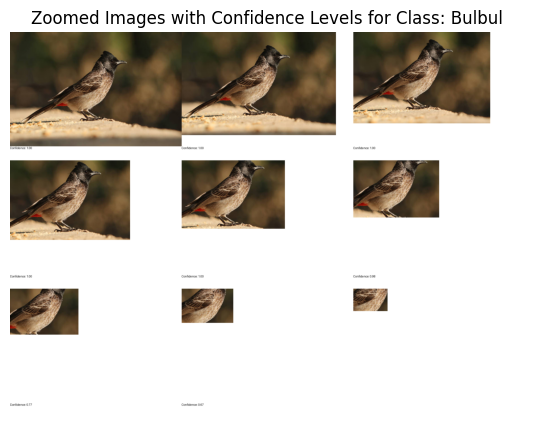

In [ ]:
# Creating and displaying composite image
composite_image = create_composite_image(zoomed_images, top_confidences, top_class_names)
plt.figure(figsize=(15, 5))
plt.imshow(composite_image)
plt.axis('off')
plt.title('Zoomed Images with Confidence Levels for Class: Bulbul')
plt.show()

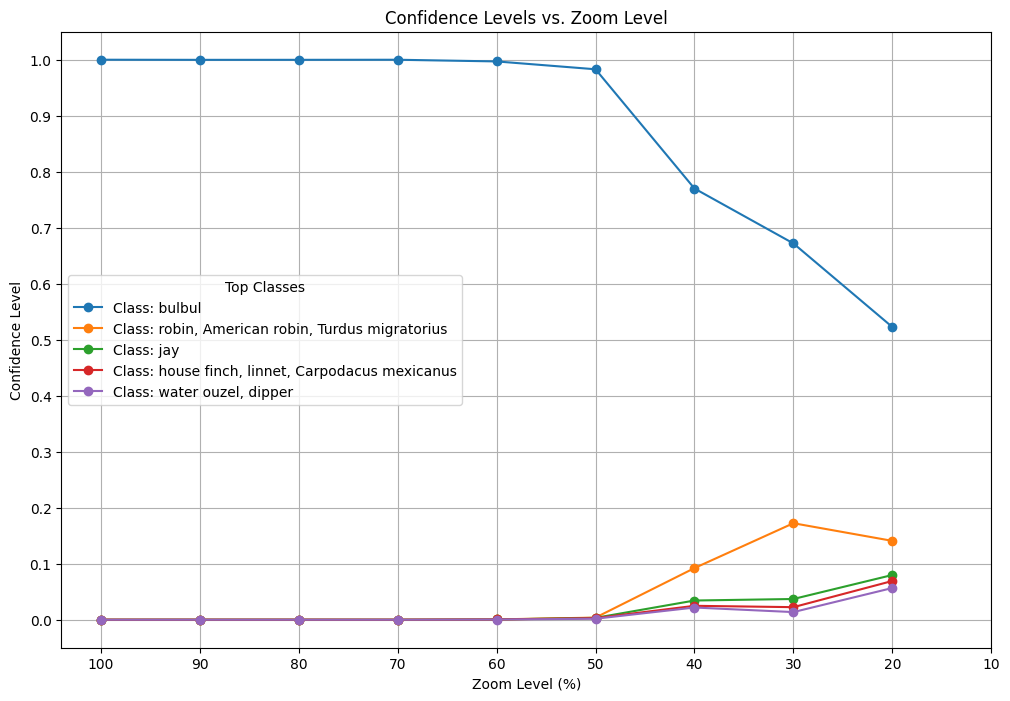

In [ ]:
# Plotting the confidence levels for the top 5 classes
plt.figure(figsize=(12, 8))
for i in range(top_k):
    plt.plot(zoom_percentages * 100, top_confidences[:, i], marker='o', label=f'Class: {top_class_names[0][i]}')

plt.title('Confidence Levels vs. Zoom Level')
plt.xlabel('Zoom Level (%)')
plt.ylabel('Confidence Level')
plt.xticks(np.arange(10, 101, 10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().invert_xaxis()
plt.legend(title="Top Classes")
plt.grid()
plt.show()